In [1]:
!pip install pdfminer
!pip install PyPDF2
!pip install pyvis

  Created wheel for pdfminer: filename=pdfminer-20191125-py3-none-any.whl size=6140106 sha256=7453314c6e25971cdac7000938634c5fe60c99c97f6e7fd7fef08c9901ebc119
  Stored in directory: c:\users\win7adm\appdata\local\pip\cache\wheels\1c\28\7d\f390b82bb0307deb63ff27a1474fd308ec68ee028cb9ab6283
Successfully built pdfminer


In [5]:

from PyPDF2 import PdfFileReader
from itertools import combinations
from collections import Counter
from itertools import chain
import random
from tqdm.notebook import tqdm, trange
import time   
import multiprocessing
import smart_open
from gensim.models.word2vec import Word2Vec
from pyvis.network import Network
from IPython.core.display import display, HTML
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

## Generate pandas Dataframe from discussion papers

In [9]:
# Initiate pandas dataframe
column_names = ["Authors", "Title", "Subject", "Creator", "Producer", "Keywords"]
df = pd.DataFrame(columns = column_names)

startnumber = 1
endnumber = 15054

for paper in range(startnumber,endnumber):
    path = "dp%d.pdf"%(paper,)
    
    try:
        with open(path, 'rb') as f:
            pdf = PdfFileReader(f)
            info = pdf.getDocumentInfo()
            if '/Keywords' in info:
                keywords = info['/Keywords']
            number_of_pages = pdf.getNumPages()
            author = info.author
            creator = info.creator
            producer = info.producer
            subject = info.subject
            title = info.title
            
            new_paper = {'Authors': author, 'Title':title, 'Subject':subject, "Creator": creator, "Producer": producer, "Keywords": keywords}
            df = df.append(new_paper, ignore_index=True)
    except:
        continue

,Authors,Title,Subject,Creator,Producer,Keywords
0,"Fabio Berton, Stefano Dughera, Andrea Ricci",Are Unions Detrimental to Innovation? Theory a...,IZA DP No. 14102,Microsoft® Word per Microsoft 365,Microsoft® Word per Microsoft 365,"innovation, labor-unions"
1,Olaf Hübler \n,None,None,None,macOS Version 10.15.7 (Build 19H2) Quartz PDFC...,"COVID-19, states, regional characteristics, pe..."


## OR Load the excel file in this repository!

In [51]:
df_cleaned = pd.read_excel('paperlist.xlsx', index_col=0) 

In [52]:
df_cleaned

,Authors,Title,Subject,Creator,Producer,Keywords
0,IZA,IZA Discussion Paper No. 1,NaN,NaN,Acrobat Distiller 4.0 for Windows,"intergenerational transmission, inheritances a..."
1,IZA,IZA Discussion Paper No. 2,NaN,C:adobeDP2VENEDIG4.WPD,Acrobat PDFWriter 3.02 für Windows,NaN
2,IZA,IZA Discussion Paper No. 3,NaN,C:adobeDP3EGYPT.WPD,Acrobat PDFWriter 3.02 für Windows,NaN
3,IZA,IZA Discussion Paper No. 4,NaN,Corel WordPerfect - [P:\Kläs\public\adobe\dp4\...,Acrobat PDFWriter 4.0 für Windows NT,NaN
4,IZA,IZA Discussion Paper No. 5,NaN,C:adobeDP5TOTAL5.WPD,Acrobat PDFWriter 3.02 für Windows,NaN
...,...,...,...,...,...,...
14997,"Ana María Ibáñez, Andrés Moya, María Adelaida ...",Life Out of the Shadows: Impacts of Amnesties ...,IZA DP No. 15049,NaN,macOS Version 12.0.1 (Build 21A559) Quartz PDF...,"migration, refugees, amnesties, Latin America"
14998,"Oded Stark, Wiktor Budzinski",The Demand for Gratitude as a Restraint on the...,IZA DP No. 15050,NaN,macOS Version 12.0.1 (Build 21A559) Quartz PDF...,"gratitude formation, the parent’s demand for c..."
14999,"Margherita Fort, Andrea Ichino, Enrico Rettore...",NaN,IZA DP No. 15051,NaN,macOS Version 12.0.1 (Build 21A559) Quartz PDF...,"regression discontinuity, multiple cutoffs, no..."
15000,"Michael Bates, Michael Dinerstein, Andrew C. J...",Teacher Labor Market Equilibrium and Student A...,IZA DP No. 15052,NaN,macOS Version 12.0.1 (Build 21A559) Quartz PDF...,"teacher labor markets, teacher and principal p..."


## Delete the first 904 rows without any meta data!

In [53]:
dfnew = df_cleaned.iloc[905:]

In [56]:
df_cleaned = dfnew

In [57]:
df_cleaned = df_cleaned.reset_index(drop=True)

In [58]:
df_cleaned.drop('Producer', axis=1, inplace=True)

In [59]:
df_cleaned.drop('Creator', axis=1, inplace=True)

In [60]:
df_cleaned.dropna()

,Authors,Title,Subject,Keywords
0,"Sandra E. Black, Paul J. Devereux, Kjell G. ...",Why the Apple Doesn’t Fall Far: Understanding ...,IZA Discussion Paper No. 926,"intergenerational mobility, education, educati..."
1,"Lorenz Goette, David Huffman, Ernst Fehr",Loss Aversion and Labor Supply,IZA Discussion Paper No. 927,"labor supply, intertemporal substitution, loss..."
2,"Harris Selod, Yves Zenou",Does City Structure Affect the Labor Market Ou...,IZA Discussion Paper No. 928,"spatial mismatch, multiple equilibria, racial ..."
3,"Zvi Eckstein, Gerard J. van den Berg",Empirical Labor Search: A Survey,IZA Discussion Paper No. 929,"job search, mobility, unemployment, wages, dur..."
4,"Maarten Lindeboom, France Portrait, Gerard J. ...",Individual Mortality and Macro-Economic Condit...,IZA Discussion Paper No. 930,"death, longevity, health, business cycle, rece..."
...,...,...,...,...
14089,"Robert A. Moffitt, Matthew V. Zahn",The Marginal Labor Supply Disincentives of Wel...,IZA DP No. 15046,"welfare, labor supply, marginal treatment effects"
14091,"Chung Choe, SeEun Jungy, Ronald L. Oaxaca",What’s the Risk from Competing? Competition Av...,IZA DP No. 15048,"gender wage gaps, wage decompositions, competi..."
14092,"Ana María Ibáñez, Andrés Moya, María Adelaida ...",Life Out of the Shadows: Impacts of Amnesties ...,IZA DP No. 15049,"migration, refugees, amnesties, Latin America"
14093,"Oded Stark, Wiktor Budzinski",The Demand for Gratitude as a Restraint on the...,IZA DP No. 15050,"gratitude formation, the parent’s demand for c..."


## Start network analysis

In [61]:
df_cleaned['test'] = df_cleaned['Authors'].str.split(',')

In [62]:
df_cleaned = df_cleaned.mask(df_cleaned.eq('None')).dropna()

### Save cleaned dataset for further use

In [63]:
def flattenList(nested_list):
    flat_list = [item for sublist in nested_list for item in sublist]
    return flat_list

In [64]:
authors=pd.DataFrame(flattenList(df_cleaned['test'].tolist())).rename(columns={0:'test'})
papers_by_authors=authors.groupby(['test']).size().reset_index().rename(columns={0:'Number of Papers Published'}).sort_values("Number of Papers Published",ascending=False)
papers_by_authors.shape

(13692, 2)

In [65]:
papers_by_authors['Number of Papers Published'].describe()

count    13692.000000
mean         2.492623
std          3.793442
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         96.000000
Name: Number of Papers Published, dtype: float64

In [66]:
## Keeping Authors who have published more than 2 Papers
nodes_to_keep=papers_by_authors.loc[papers_by_authors['Number of Papers Published']>1,'test'].tolist()
len(nodes_to_keep)

5245

In [67]:
df_cleaned['author_pairs']=df_cleaned['test'].apply(lambda x:list(combinations(x, 2)))

In [68]:
authors_pairs=df_cleaned['author_pairs'].tolist()
authors_edge_list=[item for sublist in authors_pairs for item in sublist]
authors_weighted_edge_list=list(Counter(authors_edge_list).items())
authors_weighted_edge_list=[(row[0][0],row[0][1],row[1]) for idx,row in enumerate(authors_weighted_edge_list)]
authors_weighted_edge_list[0:10]

[('Sandra E. Black', '  Paul J. Devereux', 1),
 ('Sandra E. Black', '  Kjell G. Salvanes', 1),
 ('  Paul J. Devereux', '  Kjell G. Salvanes', 1),
 ('Lorenz Goette', ' David Huffman', 6),
 ('Lorenz Goette', ' Ernst Fehr', 1),
 (' David Huffman', ' Ernst Fehr', 1),
 ('Harris Selod', ' Yves Zenou', 1),
 ('Zvi Eckstein', ' Gerard J. van den Berg', 1),
 ('Maarten Lindeboom', ' France Portrait', 1),
 ('Maarten Lindeboom', ' Gerard J. van den Berg', 1)]

In [69]:
import networkx as nx
from networkx.algorithms.components.connected import connected_components
G1=nx.Graph()
G1.add_weighted_edges_from(authors_weighted_edge_list)
print(len(G1.nodes()))

13436


In [70]:
## From the complete Graph, create a subgraph, with only the nodes to keep
sub_g=nx.subgraph(G1,nodes_to_keep)
G=nx.Graph(sub_g)
print(len(G.nodes()))
isolated_node=nx.isolates(G)
len(list(isolated_node))

5181


139

In [71]:
G.remove_nodes_from(list(nx.isolates(G)))
len(G.nodes)

5042

In [72]:
del G1, sub_g

In [73]:
print("Number of Nodes in Author Graph ",len(G.nodes()))
print("Number of Edges in AUthor Graph ",len(G.edges()))

Number of Nodes in Author Graph  5042
Number of Edges in AUthor Graph  10337


In [74]:
def getRandomWalk(graph,node,length_of_random_walk):
    """ This function takes NetworkX Graph and a Node and generate random walk for a given length 
    
    Returns the random walk (list of nodes traversed)

    Note: The same node may occcur more than once in a Random Walk.
    """
    start_node=node
    current_node=start_node
    random_walk=[node]
    for i in range(0,length_of_random_walk):
        ## Choose a random neighbour of the current node
        
        current_node_neighbours=list(graph.neighbors(current_node))
        chosen_node=random.choice(current_node_neighbours)
        current_node=chosen_node
        random_walk.append(current_node)
    return random_walk

In [76]:
### For every Node in the Graph, get randomwalks . For eahc node, let us get random walks say around 10 times each of path length 10
num_sampling=10
random_walks=[]
length_of_random_walk=10
for node in tqdm(G.nodes(),desc="Iterating Nodes"):
    
    for i in range(0,num_sampling):
        random_walks.append(getRandomWalk(G,node,length_of_random_walk))


Iterating Nodes:   0%|          | 0/5042 [00:00<?, ?it/s]

In [77]:
deepwalk_model=Word2Vec(sentences=random_walks,window=5,sg=1,negative=5,vector_size=128,epochs=20,compute_loss=True)

In [78]:
deepwalk_model.save("deepwalk_since2015.model")

In [79]:
def getSimilarNodes(model,node):
    """
    This function takes deepwalk model and a node
    
    Returns the top 10 nodes (author) similar to the given node 
    """
    similarity=model.wv.most_similar(node)
    similar_nodes=pd.DataFrame()
    similar_nodes['Similar_Node']=[row[0] for i,row in enumerate(similarity)]
    similar_nodes['Similarity_Score']=[row[1] for i,row in enumerate(similarity)]
    similar_nodes['Source_Node']=node
    return similar_nodes

In [80]:
getSimilarNodes(deepwalk_model,"Kornelius Kraft")

,Similar_Node,Similarity_Score,Source_Node
0,Stefanie Neimann,0.999283,Kornelius Kraft
1,Shareen Joshi,0.996516,Kornelius Kraft
2,Nadia S. Karamcheva,0.996376,Kornelius Kraft
3,Santosh Kumar,0.996369,Kornelius Kraft
4,T. Paul Schultz,0.996339,Kornelius Kraft
5,Michelle S. Goeree,0.996321,Kornelius Kraft
6,John C. Ham,0.996258,Kornelius Kraft
7,Daniela Iorio,0.996244,Kornelius Kraft
8,Barbara A. Butrica,0.996208,Kornelius Kraft
9,Gary S. Fields,0.996207,Kornelius Kraft


In [81]:
ai_authors=pd.DataFrame(flattenList(df_cleaned['test'].tolist())).rename(columns={0:'test'})
papers_by_authors=ai_authors.groupby(['test']).size().reset_index().rename(columns={0:'Number of Papers Published'}).sort_values("Number of Papers Published",ascending=False)
papers_by_authors

,test,Number of Papers Published
4287,Klaus F. Zimmermann,96
11548,Marco Caliendo,60
4741,Maarten van Ham,59
10904,John T. Addison,58
4665,Ludger Woessmann,51
...,...,...
5597,Minhyuk Nam,1
5598,Mintewab Bezabih,1
5599,Mira Fischer,1
5600,Miracle Ntuili,1


## Plot papers by author

Text(0, 0.5, 'Number of Papers Published')

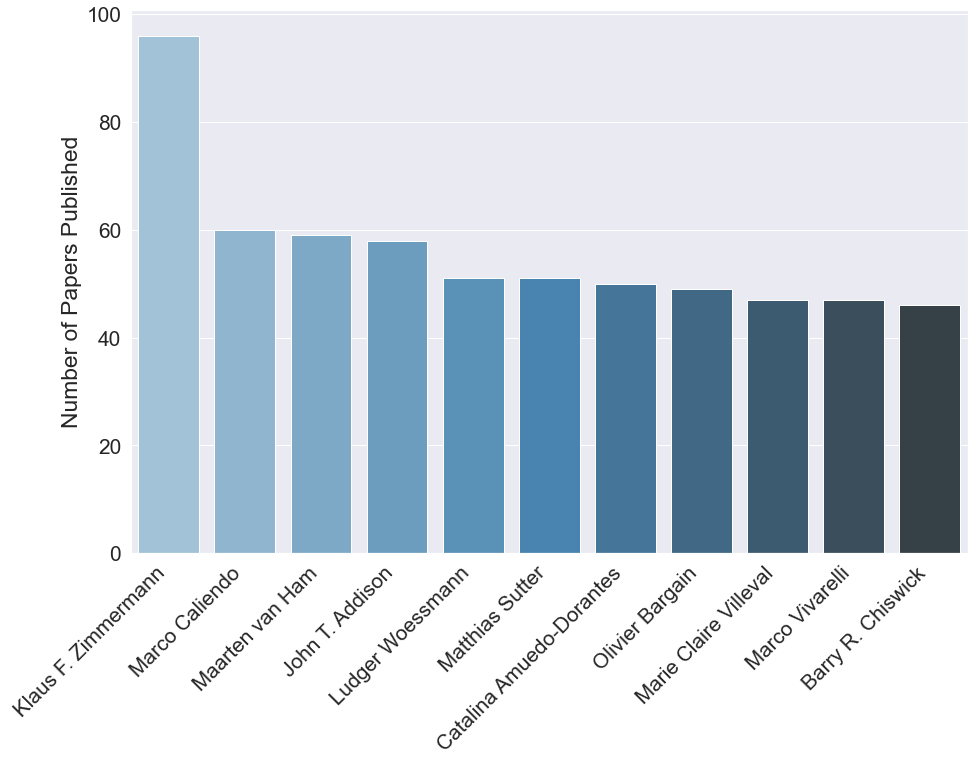

In [145]:
top10 = papers_by_authors.iloc[:11]

plt.figure(figsize=(15,10))
#top10chart = sns.catplot(y='Number of Papers Published', data=top10, kind='bar', x="test");
top10chart = sns.barplot(y='Number of Papers Published', data=top10, x="test", palette="Blues_d");
plt.xticks(rotation=45, horizontalalignment='right')
sns.set(font_scale=1.5)
plt.xlabel("")
plt.ylabel("Number of Papers Published")

In [122]:
def getCoAuthorshipNetwork(graph,initial_nodes):
    """
    This function takes a Graph and list of initial nodes 
    
    Returns the set of immediate neighbours of these nodes

    """
    total_neighbours=0
    nodes_set=[initial_nodes]
    for node in initial_nodes:
        #print(node)
        neighbours=list(graph.neighbors(node))
        total_neighbours=total_neighbours+len(neighbours)
        
        nodes_set.append(neighbours)
    print(total_neighbours)
    nodes_set=flattenList(nodes_set)
    return list(set(nodes_set))

In [123]:
coauthor_nodes=getCoAuthorshipNetwork(G,papers_by_authors['test'].tolist()[4:10])
print("Number of CoAuthor Nodes ",len(coauthor_nodes))

184
Number of CoAuthor Nodes  185


In [124]:
coauthor_subgraph=nx.subgraph(G,coauthor_nodes)
print("number of edges in the CoAuthor Subgraph ",len(coauthor_subgraph.edges()))

number of edges in the CoAuthor Subgraph  377


In [125]:
nx.write_gexf(coauthor_subgraph, "CoAuthor_Subgraph_Author4to10.gexf")

In [126]:
print("number of edges in the CoAuthor Subgraph ",len(coauthor_subgraph.edges()))

number of edges in the CoAuthor Subgraph  377


In [127]:
pyvis_nt=Network(notebook=True,height='800px', width='100%',heading='')

print("Creating PyVis from NetworkX")
pyvis_nt.from_nx(coauthor_subgraph)

print("Saving PyVis Graph")
pyvis_nt.show("Author4to10_CoAuthorGraph.html")

Creating PyVis from NetworkX
Saving PyVis Graph


In [146]:
def getCosineDistanceMatrix(vectors):
    '''
    This function takes list of vectors or numpy array 
    
    Returns the pairwise cosine similarity matrix
    '''
    if type(vectors)==list:
        X=np.asarray(vectors)
    elif type(vectors)==np.ndarray:
        X=vectors
    else:
        print("Error in Data Type . Need to Pass list or numpy array as input argument")
        return []
    cosine_dist=cosine_distances(X)
    return cosine_dist

In [147]:
coauthor_nodes=list(coauthor_subgraph.nodes)
print("Number of CoAuthor Subgraph Nodes",len(coauthor_nodes))

Number of CoAuthor Subgraph Nodes 185


In [148]:
coauthor_embeddings=[deepwalk_model.wv[node] for node in coauthor_nodes]

In [152]:
coauthor_embeddings=np.asarray(coauthor_embeddings)

print(coauthor_embeddings.shape)

(185, 128)


In [153]:
cosine_dist=getCosineDistanceMatrix(coauthor_embeddings)

In [154]:
sse=[]
k_list=[]
for k in range(2,20):
   
    km=KMeans(n_clusters=k)
    km.fit(cosine_dist)
    sse.append(km.inertia_)

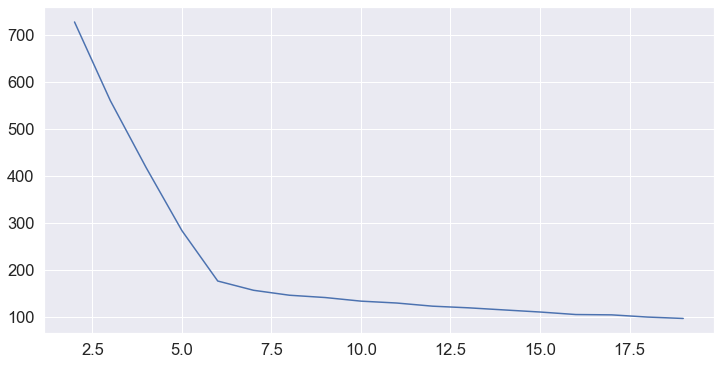

In [155]:
plt.figure(figsize=(12,6))
plt.plot([i for i in range(2,20)],sse)

In [156]:
km=KMeans(n_clusters=7)
coauthor_clusters=km.fit_predict(cosine_dist)
coauthor_cluster_dict={node:str(coauthor_clusters[idx]) for idx,node in enumerate(coauthor_nodes)}
nx.set_node_attributes(coauthor_subgraph,coauthor_cluster_dict,"group")

In [157]:
pyvis_nt=Network(notebook=True,height='600px', width='100%',heading='Author Network')

print("Creating PyVis from NetworkX")
pyvis_nt.from_nx(coauthor_subgraph)
pyvis_nt.toggle_physics(True)
print("Saving PyVis Graph")
#pyvis_nt.show_buttons()
#pyvis_nt.set_options('var options = {"edges": { "color": { "inherit": true },"smooth": false},"physics": {"hierarchicalRepulsion": { "centralGravity": 0 },"minVelocity": 0.75, "solver": "hierarchicalRepulsion","timestep": 0.18}}')


pyvis_nt.show("Author4to10_CoAuthorGraph_Clustered.html")

Creating PyVis from NetworkX
Saving PyVis Graph


## Word Cloud for keywords

In [164]:
df_cleaned["Keywords"].head(30)

0     intergenerational mobility, education, educati...
1     labor supply, intertemporal substitution, loss...
2     spatial mismatch, multiple equilibria, racial ...
3     job search, mobility, unemployment, wages, dur...
4     death, longevity, health, business cycle, rece...
5     teenage behavior, peer effects, time use, expe...
6                   crime, juvenile, twins, guns, drugs
7     work-related training, gender, fixed term cont...
8      skill bias, organisational change, manufacturing
9     formal salary systems, returns to seniority, i...
10    disability, gender, employment, wage discrimin...
11     optimal taxation, efficiency wages, unemployment
12    immigration, emigration, causes, effects, poli...
13             economic geography, education, subsidies
14    entrepreneurship, self-employment, occupationa...
15    Social Security Disability Insurance, Health a...
16    Social Security Disability Insurance, Health a...
17    severance pay, employment protection, empl